### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.pipeline import make_pipeline

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving sonar_data.csv to sonar_data.csv
User uploaded file "sonar_data.csv" with length 87776 bytes


In [ ]:
SEED = 42
from tensorflow.random import set_seed
from numpy.random import seed
seed(SEED)
set_seed(SEED)

### Loading the dataset 

In [ ]:
df = pd.read_csv('sonar_data.csv', header = None)
df = df.values
X = df[:,0:60].astype(float)
Y = df[:,60]
print ('X Shape :', X.shape)
print ('Y Shape :', Y.shape)
print ('Number of Unique Values in Y:', set(Y))

X Shape : (208, 60)
Y Shape : (208,)
Number of Unique Values in Y: {'R', 'M'}


In [ ]:
x=pd.DataFrame(X)

In [ ]:
x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,0.3108,0.2933,0.2275,0.0994,0.1801,0.2200,0.2732,0.2862,0.2034,0.1740,0.4130,0.6879,0.8120,0.8453,0.8919,0.9300,0.9987,1.0000,0.8104,0.6199,0.6041,0.5547,0.4160,0.1472,0.0849,0.0608,0.0969,0.1411,0.1676,0.1200,0.1201,0.1036,0.1977,0.1339,0.0902,0.1085,0.1521,0.1363,0.0858,0.0290,0.0203,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,0.3085,0.3425,0.2990,0.1402,0.1235,0.1534,0.1901,0.2429,0.2120,0.2395,0.3272,0.5949,0.8302,0.9045,0.9888,0.9912,0.9448,1.0000,0.9092,0.7412,0.7691,0.7117,0.5304,0.2131,0.0928,0.1297,0.1159,0.1226,0.1768,0.0345,0.1562,0.0824,0.1149,0.1694,0.0954,0.0080,0.0790,0.1255,0.0647,0.0179,0.0051,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,0.2716,0.2374,0.1878,0.0983,0.0683,0.1503,0.1723,0.2339,0.1962,0.1395,0.3164,0.5888,0.7631,0.8473,0.9424,0.9986,0.9699,1.0000,0.8630,0.6979,0.7717,0.7305,0.5197,0.1786,0.1098,0.1446,0.1066,0.1440,0.1929,0.0325,0.1490,0.0328,0.0537,0.1309,0.0910,0.0757,0.1059,0.1005,0.0535,0.0235,0.0155,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,0.2898,0.2812,0.1578,0.0273,0.0673,0.1444,0.2070,0.2645,0.2828,0.4293,0.5685,0.6990,0.7246,0.7622,0.9242,1.0000,0.9979,0.8297,0.7

### Prepping Y

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y).astype(int)
print ('Shape of Y_encoded :', len(Y_encoded))
print ('Unique values in Y_encoded :', list(set(Y_encoded)))
print ('Inverse transforming : ', encoder.inverse_transform(list(set(Y_encoded))))

Shape of Y_encoded : 208
Unique values in Y_encoded : [0, 1]
Inverse transforming :  ['M' 'R']


### Prepping X

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_transformed = ss.fit_transform(X)
X_transformed.shape

(208, 60)

In [ ]:
def baseline_model():
    
    model = Sequential()
    model.add(Dense(60, input_dim=(60), activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
    
    return model

### Building a single model

In [ ]:
single_model = baseline_model()
%time history = single_model.fit(X_transformed, Y_encoded, epochs = 200, batch_size = 8, verbose = 0, validation_split = 0.1)

CPU times: user 19.9 s, sys: 860 ms, total: 20.8 s
Wall time: 19.2 s


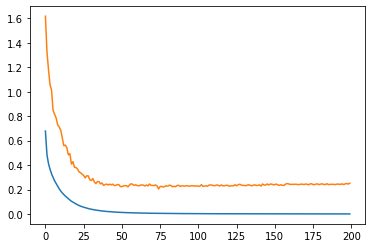

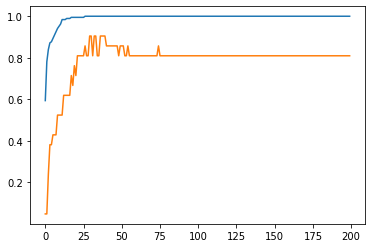

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

### Evaluating Model using K-Fold Crossvalidation

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
EPOCHS     = 50
BATCH_SIZE = 8
VERBOSE    = 0
FOLDS      = 10

In [ ]:
kfold = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
estimators = make_pipeline(StandardScaler(), KerasClassifier(build_fn = baseline_model, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = VERBOSE))
results = cross_val_score(estimators, X, Y_encoded, cv = kfold)
print (f'Mean Accuracy : {round(results.mean()*100,2)} %, Std. dev : {round(results.std()*100,2)}%')

Mean Accuracy : 87.05 %, Std. dev : 7.35%


### Trying out a small network
Reducing the number of hidden layer dimensions after the input dimension to 30 from 60 will put pressure on the network get the most important structure of the data.

In [ ]:
%%time 
def small_model():
    model = Sequential()
    model.add(Dense(30, input_dim=(60), activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
    return model

kfold = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
estimators = make_pipeline(StandardScaler(), KerasClassifier(build_fn = small_model, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = VERBOSE))
results = cross_val_score(estimators, X, Y_encoded, cv = kfold)
print (f'Mean Accuracy : {round(results.mean()*100,2)} %, Std. dev : {round(results.std()*100,2)}%')

Mean Accuracy : 84.14 %, Std. dev : 5.63%
CPU times: user 20.4 s, sys: 1.4 s, total: 21.8 s
Wall time: 17.3 s


We got an equally good model with a smaller network

### Evaluating a larger network

Evaluating a larger Network - A neural network topology with more layers offers more opportunity for the network to extract key features and combined them in useful non-linear ways

In [ ]:
%%time 
def large_model():
    model = Sequential()
    model.add(Dense(60, input_dim=(60), activation = 'relu'))
    model.add(Dense(60, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
    return model

kfold = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
estimators = make_pipeline(StandardScaler(), KerasClassifier(build_fn = large_model, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = VERBOSE))
results = cross_val_score(estimators, X, Y_encoded, cv = kfold)
print (f'Mean Accuracy : {round(results.mean()*100,2)} %, Std. dev : {round(results.std()*100,2)}%')

Mean Accuracy : 86.95 %, Std. dev : 7.97%
CPU times: user 22.8 s, sys: 1.56 s, total: 24.4 s
Wall time: 19.1 s


The accuracy improved with increased hidden layer 